In [4]:
import hls4ml
from hls4ml.model import profiling

from qkeras.qtools import run_qtools
from qkeras.utils import _add_supported_quantized_objects
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras import quantized_bits
from qkeras import QDense, QActivation
import pprint

In [5]:
from keras.models import load_model

In [15]:
import json 

f = open('models.json')
models = json.load(f)
f.close()

In [19]:
models

{'UNET': ['run-20230510_173235-nm8mu5e4'],
 'ENET': ['run-20230226_175518-8y9uyk1u'],
 'UNETv2LITE': ['run-20230227_185529-sjhgebn1'],
 'UNETv3LITE': ['run-20230303_140554-80pvvkn4'],
 'UNETv4LITE': ['run-20230308_112406-8zhdka9h'],
 'HEPAENET': ['run-20230227_181304-zog286i7'],
 'HEPCONVNET': ['run-20230227_184034-2315xvt8'],
 'UNETv5LITE': ['run-20230711_144156-d0m662qq'],
 'UNETv6LITE': ['run-20230719_183445-vpng0hra',
  'run-20230723_202540-2cjprw0q'],
 'CNN299': ['run-20230827_095927-qiut2tr0'],
 'CNN157': ['run-20230827_102010-ygc0z81i', 'run-20230827_102520-k1jv0o6v']}

In [20]:
BASE_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/"
model_dir = BASE_PATH+models["CNN299"][0]+'/files/'
model_path = model_dir+"model-best.h5"

## Model Loading

In [21]:
model = load_model(model_path)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 4)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 4)           148       
                                                                 
 up_sampling2d (UpSampling2D  (None, 10, 10, 4)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 3)         111   

In [26]:
#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
sm_layer = list(hls_config["LayerName"].keys())[-1]
hls_config['LayerName'][sm_layer]['Strategy'] = 'stable'

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using Large CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'fpga_299_10x10_xcvu13_nclock/'
cfg['Part'] = 'xcvu13p-flga2577-2-e'
cfg['ClockPeriod'] = 2.777778
cfg['ClockUncertainty'] = "30.0%"
  
hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 10, 10, 1]], output shape: [None, 10, 10, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 10, 10, 1]], output shape: [None, 10, 10, 4]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 10, 10, 4]], output shape: [None, 5, 5, 4]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 5, 5, 4]], output shape: [None, 5, 5, 4]
Layer name: up_sampling2d, layer type: UpSampling2D, input shapes: [[None, 5, 5, 4]], output shape: [None, 10, 10, 4]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 10, 10, 4]], output shape: [None, 10, 10, 3]
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 10, 10, 1]], output shape: [None, 10, 10, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 10, 10, 1]], output shape: [None, 10, 10, 4]
Layer name: max_pooling2d, layer type: MaxPooling2D, i

In [27]:
hls_model.compile()

Writing HLS project
Done


In [28]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file="UNL_12distill.png")

In [29]:
from hls4ml.model import profiling

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 10, 10, 1]], output shape: [None, 10, 10, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 10, 10, 1]], output shape: [None, 10, 10, 4]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 10, 10, 4]], output shape: [None, 5, 5, 4]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 5, 5, 4]], output shape: [None, 5, 5, 4]
Layer name: up_sampling2d, layer type: UpSampling2D, input shapes: [[None, 5, 5, 4]], output shape: [None, 10, 10, 4]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 10, 10, 4]], output shape: [None, 10, 10, 3]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

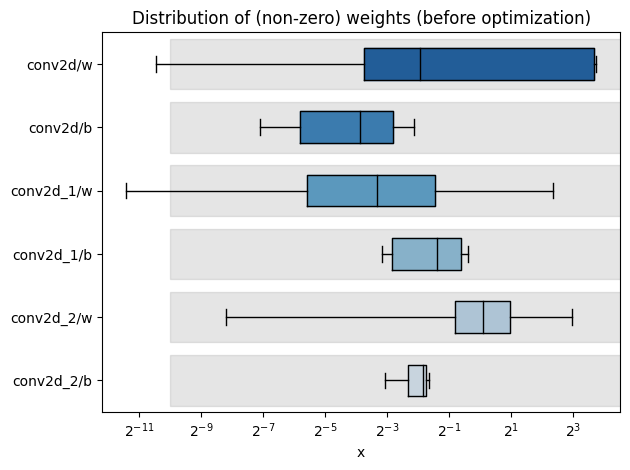

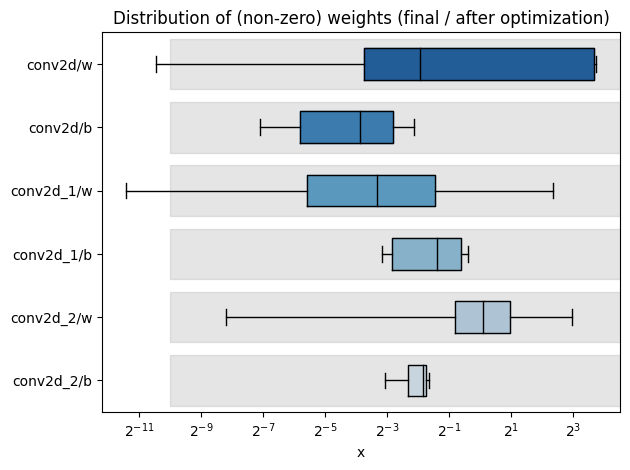

In [30]:
profiling.numerical(model=model, hls_model=hls_model)

In [31]:
# Energy Profiling dmodel: Student w/o Quantization
q = run_qtools.QTools(model, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

Instructions for updating:
Use ref() instead.
{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv2d": {
        "layer_type": "Conv2D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                3,
                3,
                1,
                4
            ]
        },
        "bias_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": 4
        },
        "multiplier": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "mul"
        },
        